# Introduction

Author: Harneet Rishi

Purpose: Generate figures and analysis for Section 3 (conditional screening)

# Imports

## Modules/packages

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.stats.multitest as smm
from scipy.special import comb
from scipy.stats import hypergeom
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')

## Functions

### Effect size calculations

In [2]:
def calc_pooled_var(n1, var1, n2, var2):
    pooled_var = np.sqrt( ((n1 - 1)*var1 + (n2-1)*var2) / (n1 + n2 - 2) )
    return pooled_var

In [3]:
def calc_cohens_d(mean_x, mean_y, pooled_var):
    cohens_d = (mean_x - mean_y) / pooled_var
    return abs(cohens_d)

## Data

### sgRNA annotations

In [4]:
df_sgRNA_info_update_3 = pd.read_csv('SourceData/APAHR007_v4_21-df_sgRNA_info_update_3.csv')
df_sgRNA_info_update_3.drop(labels = 'seq.1', inplace = True, axis = 1)
df_sgRNA_info_update_3.set_index(keys = 'seq', inplace = True, drop = False)
df_sgRNA_info_update_3.head(10)

,seq,pos,strand,category,product_name,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown)
seq,,,,,,,,
agcggtaaaattcgtgtaat,agcggtaaaattcgtgtaat,923423,+,Promoter,,NaN,NaN,0
gcgagaaaccttattaacca,gcgagaaaccttattaacca,100609,+,Promoter,,NaN,NaN,0
ggcgtgccgatgggctacgg,ggcgtgccgatgggctacgg,3046225,-,Promoter,,NaN,NaN,0
gggctacggtggcccacacg,gggctacggtggcccacacg,3046214,-,Promoter,,NaN,NaN,0
agttgtatgatgcaactagt,agttgtatgatgcaactagt,4638701,-,Promoter,,NaN,NaN,0
cgtactgctcgggcccgaaa,cgtactgctcgggcccgaaa,2751592,+,Promoter,,NaN,NaN,0
ggaaaagttttgcgctatgt,ggaaaagttttgcgctatgt,2554,+,Promoter,,NaN,NaN,0
tagtccttccccttacggga,tagtccttccccttacggga,137014,-,Promoter,,NaN,NaN,0
tggttttatatacagtaaag,tggttttatatacagtaaag,2749746,-,Promoter,,NaN,NaN,0


In [5]:
# Essential genes based on PEC database
list_genes_ess = list(set(df_sgRNA_info_update_3[df_sgRNA_info_update_3['Class(1:essential 2:noessential 3:unknown)'] == 1]['gene_name_F2'].values))

In [6]:
# Conditionally Essential Genes in M9 (1% glycerol), aerobic, T=37C (Joyce et al J.Bac 2006)
M9_ess = 'argA , argE , argH , aroA , aroB , aroC , aroE , atpA , atpB , atpC , atpF , atpG , atpH , carA , carB , cra , crr , cysA , cysB , cysC , cysD , cysE , cysH , cysI , cysJ , cysK , cysN , cysP , cysQ , cysU , fes , folB , glnA , glpD , glpK , gltA , glyA , guaA , guaB , hisA , hisB , hisC , hisD , hisF , hisG , hisH , hisI , icd , ilvA , ilvB , ilvC , ilvD , iscS , leuA , leuB , leuC , leuD , leuL , lysA , metA , metB , metC , metF , metL , metR , nadA , nadB , nadC , pabA , pabB , panB , panC , panD , panZ , pdxA , pdxB , pdxH , pdxJ , pheA , ppc , proA , proB , proC , ptsI , purA , purC , purD , purE , purF , purH , purK , purL , purM , pyrB , pyrC , pyrD , pyrE , pyrF , serA , serB , serC , thrA , thrB , thrC , thyA , trpA , trpB , trpC , trpD , trpE , tyrA , ubiG , ubiH'.split(',')
M9_ess = [g.replace(' ', '') for g in M9_ess]

In [7]:
df_M9Essential_Joyce = pd.read_table('Annotations//ConditionallyEssentialGenes_M91%glycerol_aerobic_T37C_JoyceJBac2006.txt', sep = '\t')
df_M9Essential_Joyce.set_index(keys = 'Accession-1', inplace = True, drop = False)
df_M9Essential_Joyce.head()

,All-Genes,Accession-1,Accession-2,Common-Name
Accession-1,,,,
b2818,argA,b2818,ECK2814,argA
b3957,argE,b3957,ECK3948,argE
b3960,argH,b3960,ECK3951,argH
b0908,aroA,b0908,ECK0899,aroA
b3389,aroB,b3389,ECK3376,aroB


In [8]:
# RNA annotations
df_sgRNA_info_update_RNA = pd.read_csv('SourceData/APAHR007_v4_20-df_sgRNA_info_update_RNA.csv', index_col = 0)
dict_colnames = {name:name for name in df_sgRNA_info_update_RNA.columns}
dict_colnames['seq.1'] = 'seq'
df_sgRNA_info_update_RNA.columns = [dict_colnames[name] for name in df_sgRNA_info_update_RNA.columns]
df_sgRNA_info_update_RNA

,id,pos,strand,category,gene_name,product_name,bnumber,seq,map_gene(bnumber),gene(bnumber)_split,gene_name_F,bnumber_F,RNA
seq,,,,,,,,,,,,,
ttcgaactctggaacccttt,8,1030865,+,All_Genes,serT,tRNA<SUP>serT</SUP>,b0971,ttcgaactctggaacccttt,['serT(b0971)'],['serT(b0971)'],serT,b0971,1
caaccgctcggccacacttc,9,1030915,+,All_Genes,serT,tRNA<SUP>serT</SUP>,b0971,caaccgctcggccacacttc,['serT(b0971)'],['serT(b0971)'],serT,b0971,1
gcgtcattccggagtttatg,23,3984495,-,All_Genes,glmZ,GlmZ,b4456,gcgtcattccggagtttatg,['glmZ(b4456)'],['glmZ(b4456)'],glmZ,b4456,1
ctcagtggcttagctcttga,425,1762767,+,All_Genes,rydB,RydB,b4430,ctcagtggcttagctcttga,['rydB(b4430)'],['rydB(b4430)'],rydB,b4430,1
ttttttgatatcgcctcgtt,706,4604203,+,All_Genes,leuV,tRNA<SUP>leuV</SUP>,b4368,ttttttgatatcgcctcgtt,[],['leuV(b4368)'],leuV,b4368,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ccgaacacggcggaaagggc,32509,2651558,-,All_Genes,IS128,IS128,NaN,ccgaacacggcggaaagggc,['IS128()'],['IS128()'],IS128,NaN,1
atttagcgtattatcgacac,32510,2651536,+,All_Genes,C0614,C0614,NaN,atttagcgtattatcgacac,['C0614()'],['C0614()'],C0614,NaN,1
tgaattcggactaataagcc,32511,2651592,-,All_Genes,IS128,IS128,NaN,tgaattcggactaataagcc,['IS128()'],['IS128()'],IS128,NaN,1


### p-values

In [9]:
df_topd24t0_LB = pd.read_csv('SourceData/edgeR_3-topd24t0_LB_ae.csv')
df_topd24t0_LB.set_index(keys = 'seq', inplace = True, drop = False)

df_topd24t0_M9 = pd.read_csv('SourceData/edgeR_4-topd24t0_M9_ae.csv')
df_topd24t0_M9.set_index(keys = 'seq', inplace = True, drop = False)

df_topd24t0_M9Ca = pd.read_csv('SourceData/edgeR_4-topd24t0_M9Ca_ae.csv')
df_topd24t0_M9Ca.set_index(keys = 'seq', inplace = True, drop = False)

df_topd24t0_LB_an = pd.read_csv('SourceData/edgeR_5-topd24t0_LB_anaerobic.csv')
df_topd24t0_LB_an.set_index(keys = 'seq', inplace = True, drop = False)

### Fitness values

#### Aerobic

In [10]:
df_LRs_GEq_2e6 = pd.read_csv('SourceData/APAHR007_v4_20-df_LRs_GEq_2e6.csv')
df_LRs_GEq_2e6_nmed = pd.read_csv('SourceData/APAHR007_v4_20-df_LRs_GEq_2e6_nmed.csv')
df_LRs_GEq_2e6_nmed.set_index(keys = 'seq', inplace = True, drop = False)

cols_LB = [u'd24_tR2_LR_nmed', u'd24_tR3_LR_nmed', u'ET165_LB_ae_d24_B5T2_LR_nmed', u'ET165_LB_ae_d24_B6T2_LR_nmed',
           u'ET165_R1_1.25mL_d24_LR_nmed', u'ET165_R2_1.25mL_d24_LR_nmed', u'ET165_R3.1_1mL_d24_LR_nmed',
           u'ET165_R3.2_1mL_d24_LR_nmed', u'ET165_R4_2mL_d24_LR_nmed']
cols_M9Ca = [ u'M9_B2T1_d24_Ca_LR_nmed', u'M9_B2T2_d24_Ca_LR_nmed', u'M9_B2T3_d24_Ca_LR_nmed']
cols_M9 = [u'M9_B2T1_d24_LR_nmed', u'M9_B2T2_d24_LR_nmed', u'M9_B2T3_d24_LR_nmed']

df_LRs_GEq_2e6_nmed['LB_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed[cols_LB].mean(axis = 1)
df_LRs_GEq_2e6_nmed['M9Ca_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed[cols_M9Ca].mean(axis = 1)
df_LRs_GEq_2e6_nmed['M9_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed[cols_M9].mean(axis = 1)

cols_to_transfer = [u'strand', u'category', u'product_name', u'gene_name_F2', u'bnumber_F2', 
                    u'Class(1:essential 2:noessential 3:unknown)']
for col in cols_to_transfer:
    df_LRs_GEq_2e6_nmed[col] = df_sgRNA_info_update_3[col]
    
sel_cols = ['seq','LB_ae_avgLR_nmed', 'M9Ca_ae_avgLR_nmed', 'M9_ae_avgLR_nmed',
            u'ET165_LB_ae_t0', u'M9_t0_BR2_glu+gly',
            u'category', u'product_name', u'gene_name_F2', u'bnumber_F2', 
                    u'Class(1:essential 2:noessential 3:unknown)']
df_LRs_GEq_2e6_nmed_selcols = df_LRs_GEq_2e6_nmed[sel_cols]

#### Anaerobic

In [11]:
df_LRs_GEq_2e6_nmed_an = pd.read_csv('SourceData/Anaerobic_01-df_sgRNA_counts_LRnmed_withinfo.csv')
df_LRs_GEq_2e6_nmed_an.set_index(keys = 'seq', inplace = True, drop = False)
df_LRs_GEq_2e6_nmed_an.drop(labels = 'seq.1', axis = 1, inplace = True)
cols_LB_an = [c for c in df_LRs_GEq_2e6_nmed_an.columns if 'LR_nmed' in c]
df_LRs_GEq_2e6_nmed_an['LB_an_avgLR_nmed'] = df_LRs_GEq_2e6_nmed_an[cols_LB_an].mean(axis = 1)

In [12]:
cols_drop = [c for c in df_LRs_GEq_2e6_nmed_an.columns if (('O2' in c) and not(('nmed' in c) or ('t0' in c)) )]
cols_drop

df_LRs_GEq_2e6_nmed_an_selcols = df_LRs_GEq_2e6_nmed_an[[c for c in df_LRs_GEq_2e6_nmed_an.columns if not(c in cols_drop)]]
df_LRs_GEq_2e6_nmed_an_selcols.drop(labels = ['O2_d24_1_LR_nmed', 'O2_d24_2_LR_nmed', 'O2_d24_3_LR_nmed'], axis = 1, inplace = True)
df_LRs_GEq_2e6_nmed_an_selcols['O2_t0_med'] = df_LRs_GEq_2e6_nmed_an_selcols[[c for c in df_LRs_GEq_2e6_nmed_an_selcols.columns if 'O2_t0' in c]].median(axis = 1)
df_LRs_GEq_2e6_nmed_an_selcols['LB_an_logFC'] = df_topd24t0_LB_an['logFC']
df_LRs_GEq_2e6_nmed_an_selcols['LB_an_FDR'] = df_topd24t0_LB_an['FDR']
df_LRs_GEq_2e6_nmed_an_selcols

,seq,O2_t0_1,O2_t0_2,O2_t0_3,pos,strand,category,product_name,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown),LB_an_avgLR_nmed,O2_t0_med,LB_an_logFC,LB_an_FDR
seq,,,,,,,,,,,,,,,
ggtggtgctaatgcgtttca,ggtggtgctaatgcgtttca,163.0,104.0,100.0,191,-,All_Genes,thr operon leader peptide,thrL,b0001,2,-0.217976,104.0,-0.242925,4.004926e-01
cggaatttcaccccgagcgc,cggaatttcaccccgagcgc,167.0,120.0,97.0,837587,+,All_Genes,conserved protein,ybiI,b0803,2,0.007942,120.0,-0.024016,9.991193e-01
atcggcaggcaatgtgtcgc,atcggcaggcaatgtgtcgc,161.0,95.0,80.0,858246,+,All_Genes,predicted protein,ybiU,b0821,2,-0.401922,95.0,-0.428397,7.547124e-02
tcttgactggctaatgcacg,tcttgactggctaatgcacg,180.0,97.0,86.0,1089003,+,All_Genes,poly-&beta;-16-N-acetyl-D-glucosamine N-deacet...,pgaB,b1023,2,0.146219,97.0,0.108063,8.260996e-01
ccgaactccctgattccttt,ccgaactccctgattccttt,102.0,69.0,67.0,3182919,-,All_Genes,conserved protein,yqiC,b3042,2,0.145074,69.0,0.112062,8.575393e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tgagttgatttaccgccggt,tgagttgatttaccgccggt,147.0,113.0,92.0,3182691,+,All_Genes,SroG,sroG,NaN,3,0.266227,113.0,0.237756,4.412028e-01
gagttgatttaccgccggtg,gagttgatttaccgccggtg,142.0,106.0,94.0,3182692,+,All_Genes,SroG,sroG,NaN,3,0.402920,106.0,0.379877,8.661559e-02
cgccccgccctgagaataag,cgccccgccctgagaataag,251.0,163.0,162.0,3182720,+,All_Genes,SroG,sroG,NaN,3,-1.855540,163.0,-1.791129,9.749726e-19


# Process

## Merge aerobic / anaerobic

In [13]:
df_LRs_GEq_2e6_nmed_selcols['LB_an_avgLR_nmed'] = df_LRs_GEq_2e6_nmed_an['LB_an_avgLR_nmed']
df_LRs_GEq_2e6_nmed_selcols['LB_an_logFC'] = df_LRs_GEq_2e6_nmed_an_selcols['LB_an_logFC']
df_LRs_GEq_2e6_nmed_selcols['LB_an_FDR'] = df_LRs_GEq_2e6_nmed_an_selcols['LB_an_FDR']
df_LRs_GEq_2e6_nmed_selcols['ET165_LB_an_t0'] = df_LRs_GEq_2e6_nmed_an_selcols['O2_t0_med']

In [14]:
df_LRs_GEq_2e6_nmed_selcols['LB_logFC'] = df_topd24t0_LB['logFC']
df_LRs_GEq_2e6_nmed_selcols['LB_FDR'] = df_topd24t0_LB['FDR']
df_LRs_GEq_2e6_nmed_selcols['M9_logFC'] = df_topd24t0_M9['logFC']
df_LRs_GEq_2e6_nmed_selcols['M9_FDR'] = df_topd24t0_M9['FDR']
df_LRs_GEq_2e6_nmed_selcols['M9Ca_logFC'] = df_topd24t0_M9Ca['logFC']
df_LRs_GEq_2e6_nmed_selcols['M9Ca_FDR'] = df_topd24t0_M9Ca['FDR']

In [15]:
df_LRs_GEq_2e6_nmed_selcols = df_LRs_GEq_2e6_nmed_selcols[[u'LB_ae_avgLR_nmed', u'M9Ca_ae_avgLR_nmed', u'M9_ae_avgLR_nmed', u'LB_an_avgLR_nmed',
                                                          u'ET165_LB_ae_t0', u'M9_t0_BR2_glu+gly', u'ET165_LB_an_t0',
                                                          u'category', u'product_name', u'gene_name_F2', u'bnumber_F2', u'Class(1:essential 2:noessential 3:unknown)',
                                                          u'LB_logFC', u'LB_FDR', u'M9Ca_logFC', u'M9Ca_FDR', u'M9_logFC', u'M9_FDR', u'LB_an_logFC', u'LB_an_FDR',
                                                          u'seq']]

In [16]:
df_LRs_GEq_2e6_nmed_selcols

,LB_ae_avgLR_nmed,M9Ca_ae_avgLR_nmed,M9_ae_avgLR_nmed,LB_an_avgLR_nmed,ET165_LB_ae_t0,M9_t0_BR2_glu+gly,ET165_LB_an_t0,category,product_name,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown),LB_logFC,LB_FDR,M9Ca_logFC,M9Ca_FDR,M9_logFC,M9_FDR,LB_an_logFC,LB_an_FDR,seq
seq,,,,,,,,,,,,,,,,,,,,,
ggtggtgctaatgcgtttca,0.189134,-0.027225,-5.074150,-0.217976,88.0,32.0,104.0,All_Genes,thr operon leader peptide,thrL,b0001,2,-0.076977,8.250651e-01,-0.100777,9.833974e-01,-8.167145,3.711483e-17,-0.242925,4.004926e-01,ggtggtgctaatgcgtttca
cggaatttcaccccgagcgc,0.462671,0.044080,0.368444,0.007942,83.0,44.0,120.0,All_Genes,conserved protein,ybiI,b0803,2,0.326304,1.805491e-01,0.016211,1.000000e+00,0.194010,7.130471e-01,-0.024016,9.991193e-01,cggaatttcaccccgagcgc
atcggcaggcaatgtgtcgc,0.102828,0.509944,0.971665,-0.401922,61.0,21.0,95.0,All_Genes,predicted protein,ybiU,b0821,2,-0.118003,8.273442e-01,0.453822,5.916171e-01,0.863861,5.937241e-02,-0.428397,7.547124e-02,atcggcaggcaatgtgtcgc
tcttgactggctaatgcacg,0.245104,0.053096,0.414547,0.146219,92.0,36.0,97.0,All_Genes,poly-&beta;-16-N-acetyl-D-glucosamine N-deacet...,pgaB,b1023,2,0.168139,6.176843e-01,-0.018413,1.000000e+00,0.250438,6.599628e-01,0.108063,8.260996e-01,tcttgactggctaatgcacg
ccgaactccctgattccttt,-0.135161,-1.398016,-0.414700,0.145074,55.0,26.0,69.0,All_Genes,conserved protein,yqiC,b3042,2,-0.029368,9.817026e-01,-1.413050,7.788927e-03,-0.588996,3.223662e-01,0.112062,8.575393e-01,ccgaactccctgattccttt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tgagttgatttaccgccggt,-0.481508,-1.887248,-0.895022,0.266227,89.0,36.0,113.0,All_Genes,SroG,sroG,NaN,3,-0.535869,8.774736e-02,-2.021699,1.994269e-05,-1.103800,1.426030e-02,0.237756,4.412028e-01,tgagttgatttaccgccggt
gagttgatttaccgccggtg,-0.456681,-2.080028,-1.397872,0.402920,84.0,48.0,106.0,All_Genes,SroG,sroG,NaN,3,-0.589171,6.142389e-02,-2.174852,1.176363e-07,-1.594958,7.284878e-05,0.379877,8.661559e-02,gagttgatttaccgccggtg
cgccccgccctgagaataag,-4.504771,-4.486742,-5.521609,-1.855540,114.0,44.0,163.0,All_Genes,SroG,sroG,NaN,3,-3.923483,4.732126e-20,-5.202462,7.579475e-16,-8.625207,1.469660e-19,-1.791129,9.749726e-19,cgccccgccctgagaataag


In [17]:
#df_LRs_GEq_2e6_nmed_selcols.to_csv('Section 3/df_LRs_GEq_2e6_nmed_selcols_MERGE.csv')

## Filter fitness data and calc gene fitness

In [18]:
df_LRs_GEq_2e6_nmed_selcols_filt = df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols['ET165_LB_ae_t0'] >= 10]
df_LRs_GEq_2e6_nmed_an_selcols_filt = df_LRs_GEq_2e6_nmed_an_selcols[df_LRs_GEq_2e6_nmed_an_selcols['O2_t0_med'] >= 10]

In [19]:
len(df_LRs_GEq_2e6_nmed_selcols_filt), len(df_LRs_GEq_2e6_nmed_selcols)

(29953, 32992)

In [20]:
df_LRs_GEq_2e6_nmed_selcols_filt_AllGenes = df_LRs_GEq_2e6_nmed_selcols_filt[df_LRs_GEq_2e6_nmed_selcols_filt['category'] == 'All_Genes']
df_LRs_GEq_2e6_nmed_an_selcols_filt_AllGenes = df_LRs_GEq_2e6_nmed_an_selcols_filt[df_LRs_GEq_2e6_nmed_an_selcols_filt['category'] == 'All_Genes']

In [21]:
df_LRs_GEq_2e6_nmed_selcols_filt_AllGenes_gpby = df_LRs_GEq_2e6_nmed_selcols_filt_AllGenes.groupby('gene_name_F2').median()
df_LRs_GEq_2e6_nmed_selcols_filt_AllGenes_gpby['gene_name_F2'] = df_LRs_GEq_2e6_nmed_selcols_filt_AllGenes_gpby.index
df_LRs_GEq_2e6_nmed_an_selcols_filt_AllGenes_gpby = df_LRs_GEq_2e6_nmed_an_selcols_filt_AllGenes.groupby('gene_name_F2').median()
df_LRs_GEq_2e6_nmed_an_selcols_filt_AllGenes_gpby['gene_name_F2'] = df_LRs_GEq_2e6_nmed_an_selcols_filt_AllGenes_gpby.index

In [22]:
common_genes = [g for g in df_LRs_GEq_2e6_nmed_selcols_filt_AllGenes_gpby['gene_name_F2'].unique() if 
 g in set(df_LRs_GEq_2e6_nmed_an_selcols_filt_AllGenes_gpby['gene_name_F2'].unique())]

df_LRs_GEq_2e6_nmed_selcols_filt_AllGenes_gpby_common = df_LRs_GEq_2e6_nmed_selcols_filt_AllGenes_gpby.loc[common_genes]
df_LRs_GEq_2e6_nmed_an_selcols_filt_AllGenes_gpby_common = df_LRs_GEq_2e6_nmed_an_selcols_filt_AllGenes_gpby.loc[common_genes]

df_comb = df_LRs_GEq_2e6_nmed_selcols_filt_AllGenes_gpby_common.copy()
df_comb['LB_an_avgLR_nmed'] = df_LRs_GEq_2e6_nmed_an_selcols_filt_AllGenes_gpby_common['LB_an_avgLR_nmed']
df_comb['LB_an_logFC'] = df_LRs_GEq_2e6_nmed_an_selcols_filt_AllGenes_gpby_common['LB_an_logFC']
df_comb['LB_an_FDR'] = df_LRs_GEq_2e6_nmed_an_selcols_filt_AllGenes_gpby_common['LB_an_FDR']

In [23]:
df_comb[['LB_ae_avgLR_nmed', 'LB_an_avgLR_nmed']].describe()

,LB_ae_avgLR_nmed,LB_an_avgLR_nmed
count,4442.000000,4442.000000
mean,-0.500114,-0.486919
std,1.706840,1.604303
min,-8.323337,-8.459869
25%,-0.104527,-0.104338
50%,0.087035,0.058249
75%,0.191369,0.148351
max,0.934338,1.482108


# Figures

## Figure 3a

### Scope parameters

In [24]:
aerobic_genes_pyruvate_TCA = ['pdhR', 'aceE', 'aceF', 'lpd']

aerobic_genes_hemebiosynth = ['hemA', 'hemB', 'hemC', 'hemD', 'hemE', 'hemF', 'hemG', 'hemH', 'hemL', 'hemN', 'hemY']
aerobic_genes_hemebiosynth_order = ['hemA', 'hemL', 'hemB', 'hemC', 'hemD', 'hemE', 'hemF', 'hemN', 'hemG', 'hemY', 'hemH']

aerobic_genes_ubiquinonesynth = ['ispB', 'ubiC', 'ubiA', 'ubiD', 'ubiI', 'ubiG', 'ubiH', 'ubiE', 'ubiF', 
                                 'yigP', 'yqiC', 'ubiX'] #yqiC (ubiK), yigP (ubiJ)

aerobic_genes_cytochrome_bdI = ['cydA', 'cydB', 'ybgT'] #ybgT (cydX); removed cydC and not showing cydD
aerobic_genes_cytochrome_bdII = ['appB', 'appC']
aerobic_genes_cytochrome_bo = ['cyoA', 'cyoB', 'cyoC', 'cyoD']

aerobic_genes_NADH_quinone_oxidoreductase = ['nuoA', 'nuoB', 'nuoC', 'nuoE', 'nuoF', 'nuoG',
                                             'nuoH', 'nuoI', 'nuoJ', 'nuoK', 'nuoL', 'nuoM', 'nuoN',
                                            'ndh']

aerobic_genes_ATPsynthase = list(df_comb[df_comb['gene_name_F2'].str.contains('atp')]['gene_name_F2'].values)

aerobic_genes_ribonucleotide = ['nrdA', 'nrdB'] #removed yfaE

anaerobic_genes = ['arcA', 'arcB', 'fnr', 'focA'] #remove sokC, dksA, erpA

other_genes = ['nrdA', 'nrdB', 'arcA', 'arcB', 'fnr', 'focA'] #remove erpA

### Visualize

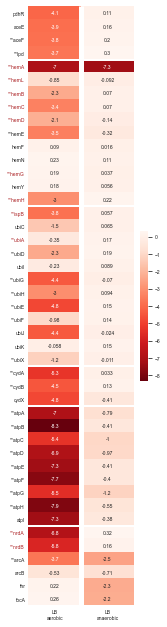

In [25]:
sns.set_style('white')
fig = plt.figure(figsize = (60/25.4,280/25.4))
ax111 = fig.add_subplot(1,1,1)

gene_groups = [aerobic_genes_pyruvate_TCA,
              aerobic_genes_hemebiosynth_order, aerobic_genes_ubiquinonesynth,
              aerobic_genes_cytochrome_bdI,
              aerobic_genes_ATPsynthase,
              other_genes]

list_spacings = []
genes_to_viz = []
counter = 0
for gene_group in gene_groups:
    genes_to_viz += gene_group
    list_spacings.append(len(gene_group) + counter)
    counter += len(gene_group)
    

i = 0
for gene_group in gene_groups:
    if i == 0:
        df_comb_selgenes = df_comb[df_comb['gene_name_F2'].isin(gene_group)]
        i += 1
    else:
        df_comb_selgenes = pd.concat([df_comb_selgenes, df_comb[df_comb['gene_name_F2'].isin(gene_group)]], axis = 0)
        
df_comb_selgenes = df_comb_selgenes.loc[genes_to_viz]
df_comb_selgenes.rename(index = {'ybgT': 'cydX', 'yigP': 'ubiJ', 'yqiC': 'ubiK'}, inplace = True) #changing between equivalent gene names

list_selgenes_Egenes = df_comb_selgenes[df_comb_selgenes['Class(1:essential 2:noessential 3:unknown)'] == 1]['gene_name_F2'].values
list_selgenes_NotCoveredRbTnSeq = ['aceF', 'lpd', 'hemA','hemL','hemB','hemC','hemD','hemE','hemG','hemH','ispB',
                                   'ubiA','ubiD','ubiG','ubiH','ubiE','ubiF','ubiX',
                                   'cydA','cydB','cydC',
                                   'atpA','atpB','atpC','atpD','atpE','atpF','atpG','atpH',
                                   'nrdA','nrdB','arcA']
dict_gene_NotCoveredRbTnSeq = {g: '**%s' %g for g in list_selgenes_NotCoveredRbTnSeq}
df_comb_selgenes.rename(index = dict_gene_NotCoveredRbTnSeq, inplace = True) #annotate genes not covered by RbTnSeq for figure viz

sns.heatmap(df_comb_selgenes[[c for c in df_comb.columns if ('LB' in c and 'LR' in c)]], cmap="Reds_r", annot = True, annot_kws={"size": 5},
           cbar_kws = {'shrink': 0.25, 'aspect':20})

ax111.hlines(list_spacings, *ax111.get_xlim(), color = 'white', linewidth = 2)
ax111.vlines([1], *ax111.get_ylim(), color = 'white', linewidth = 5)
plt.yticks(rotation = 0);
plt.ylabel('')
plt.tick_params('both', labelsize = 5)
plt.xticks([0.5, 1.5], ['LB\naerobic', 'LB\nanaerobic'], rotation = 0);

cbar = ax111.collections[0].colorbar
cbar.ax.tick_params(labelsize=5)

df_comb_selgenes_reind = df_comb_selgenes.reset_index(drop = True)
for i in df_comb_selgenes_reind[df_comb_selgenes_reind['Class(1:essential 2:noessential 3:unknown)'] == 1].index.values:
    ax111.get_yticklabels()[i].set_color('#AE282B')
ax111.get_xaxis().set_tick_params(direction='in', width=0)
ax111.get_yaxis().set_tick_params(direction='in', width=0)
    
plt.savefig('Section 3/Fig_3_a.pdf', type = 'pdf')

### Data Export

In [26]:
df_Fig3a = df_comb_selgenes[[c for c in df_comb.columns if ('LB' in c and 'LR' in c)]].reset_index()
df_Fig3a.to_excel('Section 3/Table_Fig-3a.xlsx')
df_Fig3a

,gene_name_F2,LB_ae_avgLR_nmed,LB_an_avgLR_nmed
0,pdhR,-4.102401,0.108512
1,aceE,-3.882109,0.155634
2,**aceF,-3.845501,0.202115
3,**lpd,-3.725637,0.303967
4,**hemA,-6.989567,-7.296282
5,**hemL,-0.853789,-0.092474
6,**hemB,-2.298479,0.070202
7,**hemC,-3.367828,0.070263
8,**hemD,-2.148390,-0.137512
9,**hemE,-3.460027,-0.315340


## Supplementary Information: Minimal Media Essential Genes

### Visualize

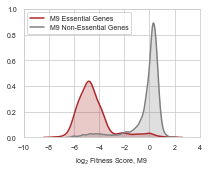

In [27]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (80/25.4, 60/25.4))
plt.rcParams["font.family"] = "Arial"
ax111 = fig.add_subplot(1,1,1)

threshold_t0 = 10
df_iter = df_LRs_GEq_2e6_nmed.copy()
df_iter = df_iter[df_iter['category'] == 'All_Genes']
df_iter_filt = df_iter[df_iter['M9_t0_BR2_glu+gly'] >= threshold_t0]
df_iter_filt = df_iter_filt.groupby('gene_name_F2').median()
df_iter_filt['gene_name_F2'] = df_iter_filt.index

#make df of LB (PEC) and M9 (Joyce2006) essential genes
df_iter_filt_M9Ess = df_iter_filt[(df_iter_filt['Class(1:essential 2:noessential 3:unknown)'] == 1) | 
                                 (df_iter_filt['gene_name_F2'].isin(df_M9Essential_Joyce['All-Genes'].values))]

#all other genes are non-essential
df_iter_filt_M9NEss = df_iter_filt[(df_iter_filt['Class(1:essential 2:noessential 3:unknown)'] != 1) & 
                                 ~(df_iter_filt['gene_name_F2'].isin(df_M9Essential_Joyce['All-Genes'].values))]

sns.kdeplot(df_iter_filt_M9Ess['M9_ae_avgLR_nmed'], color = '#AE282B', label = 'M9 Essential Genes', shade = True)
sns.kdeplot(df_iter_filt_M9NEss['M9_ae_avgLR_nmed'], color = 'gray', label = 'M9 Non-Essential Genes', shade = True)

ax111.set_xlabel('log$_2$ Fitness Score, M9', fontsize = 7)
plt.tick_params(axis = 'both', which = 'major', labelsize = 7)

plt.legend(loc = 'upper left', fontsize = 7, frameon = True)
ax111.set_xlim(-10,4)
ax111.set_ylim(0,1)

plt.savefig('Section 3/SuppFig_M9EssvsNEssgenes_th10.pdf', type = 'pdf')

### Stats

In [28]:
len(df_iter_filt_M9Ess[df_iter_filt_M9Ess['M9_ae_avgLR_nmed'] <= -2]), len(df_iter_filt_M9Ess), (len(df_iter_filt_M9Ess[df_iter_filt_M9Ess['M9_ae_avgLR_nmed'] <= -2])/len(df_iter_filt_M9Ess))

(385, 415, 0.927710843373494)

In [29]:
# Mann-whitney U-test
x = df_iter_filt_M9Ess['M9_ae_avgLR_nmed'].values
y = df_iter_filt_M9NEss['M9_ae_avgLR_nmed'].values
statistics, pvalue = mannwhitneyu(x, y, alternative='two-sided')
statistics, pvalue

(76151.5, 1.2946054957180662e-204)

In [30]:
# Cohen's d effect size calculation
x = df_iter_filt_M9Ess['M9_ae_avgLR_nmed'].values
y = df_iter_filt_M9NEss['M9_ae_avgLR_nmed'].values
mean_x = np.mean(x)
mean_y = np.mean(y)
pooled_var = calc_pooled_var(len(x), np.var(x), len(y), np.var(y))
cohens_d = calc_cohens_d(mean_x, mean_y, pooled_var)
cohens_d

3.2316110615504647

### Data Export

In [31]:
df_SuppFig2 = pd.concat([df_iter_filt_M9Ess, df_iter_filt_M9NEss], axis=0)
df_SuppFig2.loc[df_iter_filt_M9Ess.index, 'M9 Essential Gene'] = True
df_SuppFig2.loc[df_iter_filt_M9NEss.index, 'M9 Essential Gene'] = False
df_SuppFig2 = df_SuppFig2[['M9_ae_avgLR_nmed', 'M9_t0_BR2_glu+gly', 'M9 Essential Gene']].reset_index(drop=False)
df_SuppFig2.to_excel('Section 3/Table_SuppFig-2.xlsx')
df_SuppFig2

,gene_name_F2,M9_ae_avgLR_nmed,M9_t0_BR2_glu+gly,M9 Essential Gene
0,accA,-4.584345,46.0,True
1,accB,-5.541315,60.0,True
2,accC,-4.093976,34.5,True
3,accD,-5.682217,49.5,True
4,acpP,-3.978533,92.5,True
...,...,...,...,...
4430,zraR,0.253424,58.5,False
4431,zraS,0.794654,50.0,False
4432,zupT,-0.716797,63.5,False
4433,zur,-0.491812,62.5,False


## Supplementary Information: M9 vs M9Ca conditional essentiality

### Scope parameters

In [32]:
#Ecocyc annotations for amino acid metabolism
ecocyc_aa = ['hisG','hisF','hisH','leuD','leuB','argE','serC','asnB','argD','cysM','argC','hisA','serB','mtn','ilvN','ilvE',
'serA','asd','pheA','dapD','cysE','trpB','trpA','glyA','proB','dapA','carA','argB','argA','leuC','gltD','gltB',
'leuA','lysC','ilvB','tyrA','proA','hisD','hisB','hisC','ilvC','ilvD','ilvA','tyrB','dapB','ivbL','asnA','metB',
'thrC','trpC','trpD','trpE','ilvH','ilvI','metL','thrA','thrB','usg','ridA','aspA','malY','cysK','proC','mmuM',
'ilvL','hisL','cysJ','metE','folD','cysI','aroE','aroC','argH','metF','dapE','aroM','ilvM','trpL','thrL','leuL',
'aroG','metR','cysB','metJ','dapF','cysZ','argG','aroL','aroK','ydiB','aroA','argR','aroB','metA','hisI','argF',
'metC','ilvY','aroD','argI','aroF','aroH','lysA']

### Visualize

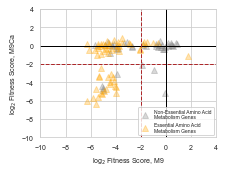

In [33]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (80/25.4, 60/25.4))
plt.rcParams["font.family"] = "Arial"
ax111 = fig.add_subplot(1,1,1)

threshold_t0 = 10
df_iter = df_LRs_GEq_2e6_nmed.copy()
df_iter = df_iter[df_iter['category'] == 'All_Genes']
df_iter_filt = df_iter[df_iter['M9_t0_BR2_glu+gly'] >= threshold_t0]
df_iter_filt = df_iter_filt.groupby('gene_name_F2').median()
df_iter_filt['gene_name_F2'] = df_iter_filt.index

x_col = 'M9_ae_avgLR_nmed'
y_col = 'M9Ca_ae_avgLR_nmed'

#make df of LB (PEC) and M9 (Joyce2006) essential genes
df_iter_filt_M9Ess = df_iter_filt[(df_iter_filt['Class(1:essential 2:noessential 3:unknown)'] == 1) | 
                                 (df_iter_filt['gene_name_F2'].isin(df_M9Essential_Joyce['All-Genes'].values))]

#all other genes are non-essential
df_iter_filt_M9NEss = df_iter_filt[(df_iter_filt['Class(1:essential 2:noessential 3:unknown)'] != 1) & 
                                 ~(df_iter_filt['gene_name_F2'].isin(df_M9Essential_Joyce['All-Genes'].values))]

#ecocyc amino acid metabolism genes
df_iter_filt_ecocyc_aa = df_iter_filt[df_iter_filt['gene_name_F2'].isin(ecocyc_aa)]

#check which aa metabolism genes are supposed to be essential in M9
ecocyc_aa_M9Ess = [gene for gene in df_iter_filt_ecocyc_aa['gene_name_F2'] if gene in df_iter_filt_M9Ess['gene_name_F2'].values]
#check which aa metabolism genes aren't supposed to be essential in M9
ecocyc_aa_M9NEss = [gene for gene in df_iter_filt_ecocyc_aa['gene_name_F2'] if not(gene in df_iter_filt_M9Ess['gene_name_F2'].values)]
ecocyc_aa_LBEss = [gene for gene in df_iter_filt_ecocyc_aa['gene_name_F2'] if 
                   (gene in df_iter_filt[df_iter_filt['Class(1:essential 2:noessential 3:unknown)'] == 1]['gene_name_F2'].values)]


df_iter_filt_ecocyc_aa_M9Ess = df_iter_filt[df_iter_filt['gene_name_F2'].isin(ecocyc_aa_M9Ess)]
df_iter_filt_ecocyc_aa_M9NEss = df_iter_filt[df_iter_filt['gene_name_F2'].isin(ecocyc_aa_M9NEss)]
df_iter_filt_ecocyc_aa_LBEss = df_iter_filt[df_iter_filt['gene_name_F2'].isin(ecocyc_aa_LBEss)]


plt.scatter(df_iter_filt_ecocyc_aa_M9NEss[x_col], df_iter_filt_ecocyc_aa_M9NEss[y_col],
           alpha = 0.3, label = "Non-Essential Amino Acid\nMetabolism Genes", color = 'gray', marker = '^')
plt.scatter(df_iter_filt_ecocyc_aa_M9Ess[x_col], df_iter_filt_ecocyc_aa_M9Ess[y_col],
           alpha = 0.3, label = "Essential Amino Acid\nMetabolism Genes", color = 'orange', marker = '^')
#plt.scatter(df_iter_filt_ecocyc_aa_LBEss[x_col], df_iter_filt_ecocyc_aa_LBEss[y_col],
#           alpha = 0.3, color = 'orange')

plt.axvline(x=0,linestyle = '-', color = 'k',linewidth = 1)
plt.axhline(y=0,linestyle = '-', color = 'k',linewidth = 1)
plt.axvline(x=-2,linestyle = '--', color = '#AE282B',linewidth = 1)
plt.axhline(y=-2,linestyle = '--', color = '#AE282B',linewidth = 1)

ax111.set_xlabel('log$_2$ Fitness Score, M9', fontsize = 7)
ax111.set_ylabel('log$_2$ Fitness Score, M9Ca', fontsize = 7)
ax111.set_xlim(-10,4)
ax111.set_ylim(-10,4)

plt.tick_params(axis = 'both', which = 'major', labelsize = 7)
plt.legend(loc = 'lower right', fontsize = 5, frameon = True)

plt.savefig('Section 3/SuppFig_M9vsM9CaGeneScoresv2_tht0=10.pdf', type = 'pdf')

### Data Export

In [34]:
df_SuppFig4 = pd.concat([df_iter_filt_ecocyc_aa_M9Ess, df_iter_filt_ecocyc_aa_M9NEss], axis=0)
df_SuppFig4.loc[df_iter_filt_ecocyc_aa_M9Ess.index, 'M9 Essential Amino Acid Metabolism Gene'] = True
df_SuppFig4.loc[df_iter_filt_ecocyc_aa_M9NEss.index, 'M9 Essential Amino Acid Metabolism Gene'] = False
df_SuppFig4 = df_SuppFig4[['M9_ae_avgLR_nmed', 'M9_t0_BR2_glu+gly', 'M9 Essential Amino Acid Metabolism Gene']].reset_index(drop=False)
df_SuppFig4.to_excel('Section 3/Table_SuppFig-4.xlsx')
df_SuppFig4

,gene_name_F2,M9_ae_avgLR_nmed,M9_t0_BR2_glu+gly,M9 Essential Amino Acid Metabolism Gene
0,argA,-4.725772,44.5,True
1,argE,-1.027132,38.0,True
2,argH,-5.208257,54.5,True
3,aroA,-4.477165,23.0,True
4,aroB,-4.964938,38.5,True
...,...,...,...,...
95,ridA,0.198035,29.0,False
96,thrL,-4.307598,31.5,False
97,tyrB,-0.283133,56.0,False
98,usg,-5.026932,43.5,False


## Supplementary Information: hok-sok toxin-antitoxin system

### Process

In [35]:
genes_to_compare = ['sokB','hokB','mokC','sokC','hokC','mokB']
cols_LB_keep = [u'd24_tR2_LR_nmed', u'd24_tR3_LR_nmed', u'ET165_LB_ae_d24_B5T2_LR_nmed', u'ET165_LB_ae_d24_B6T2_LR_nmed', 
                u'ET165_R1_1.25mL_d24_LR_nmed', u'ET165_R2_1.25mL_d24_LR_nmed', u'ET165_R3.1_1mL_d24_LR_nmed', 
                u'ET165_R3.2_1mL_d24_LR_nmed', u'ET165_R4_2mL_d24_LR_nmed', 'gene_name_F2']
cols_M9_keep = [u'M9_B2T1_d24_LR_nmed', u'M9_B2T1_d24_Ca_LR_nmed', u'M9_B2T2_d24_LR_nmed', 
                u'M9_B2T2_d24_Ca_LR_nmed', u'M9_B2T3_d24_LR_nmed', u'M9_B2T3_d24_Ca_LR_nmed', 'gene_name_F2']

df_TA_LB = df_LRs_GEq_2e6_nmed[df_LRs_GEq_2e6_nmed['gene_name_F2'].isin(genes_to_compare)][cols_LB_keep]
df_TA_LB.columns = ['LB_1', 'LB_2', 'LB_3', 'LB_4', 'LB_5', 'LB_6', 'LB_7', 'LB_8', 'LB_9', 'gene_name_F2']
df_TA_M9 = df_LRs_GEq_2e6_nmed[df_LRs_GEq_2e6_nmed['gene_name_F2'].isin(genes_to_compare)][cols_M9_keep]
df_TA_M9.columns = ['M9_1', 'M9Ca_1', 'M9_2', 'M9Ca_2', 'M9_3', 'M9Ca_3', 'gene_name_F2']
df_TA_M9 = df_TA_M9[['M9Ca_1', 'M9Ca_2', 'M9Ca_3', 'M9_1', 'M9_2', 'M9_3', 'gene_name_F2']]

In [36]:
df_TA = pd.concat(objs = [df_TA_LB, df_TA_M9], axis = 1)
df_TA.drop(labels = 'gene_name_F2', axis = 1, inplace = True)
df_TA['gene_name_F2'] = df_TA_M9['gene_name_F2']
df_TA_filt = df_TA.drop(labels = ['ctttctccttgccggatggc'], axis = 0) #drop b/c low coverage in M9_t0
df_TA_filt['seq'] = df_TA_filt.index
df_TA_filt.set_index(keys = ['gene_name_F2','seq'], inplace = True, drop = True)
df_TA_filt

LB_1      LB_2      LB_3      LB_4  \
gene_name_F2 seq                                                            
hokB         caacctccttatcaccgtcc  0.219466  0.487080  0.355975 -0.015874   
             cgtagagcgtttgtcgggtc  0.439210  0.334920  0.223588  0.461079   
             atgagcagacacaccaccag  0.444320  0.170189  0.501256 -0.310340   
             tgagcagacacaccaccaga  0.263117  0.007739  0.375796 -0.105082   
mokB         tagcctttctccttgccgga  0.497526  0.027523  0.433511 -0.022026   
sokB         accgatatttctatcaaccg  0.058666 -0.551514  0.094025  0.137119   
mokC         ttcggatgtgaacctcacag -0.032791 -0.004371  0.029487  0.252329   
             taccagcgccgccactacgg  0.169647  0.148230  0.216281  0.125090   
             ctctcttctccttgacctta  0.467779  0.407627  0.348264  0.239920   
             ttgaccttacggtcagtaag  0.794589  0.559918  0.981948  0.906123   
sokC         gatattttaccatcaacccg -0.580584 -0.949756  0.314867 -0.853050   

                                       LB_5      LB_6      LB_7      LB_8  \
gene_name_F2 seq                                                            
hokB         caacctccttatcaccgtcc  0.254187  0.095420 -0.004446  0.215812   
             cgtagagcgtttgtcgggtc  0.557995  1.098921  0.202372  0.755110   
             atgagcagacacaccaccag  0.071866  0.060916  0.014816  0.598065   
             tgagcagacacaccaccaga -0.045704  0.188466  0.384371  0.523599   
mokB         tagcctttctccttgccgga  0.309855  1.164688 -0.473931 -0.059501   
sokB         accgatatttctatcaaccg  0.342559 -0.186133  0.294743  0.611876   
mokC         ttcggatgtgaacctcacag -0.149163  0.005782 -0.254024 -0.381429   
             taccagcgccgccactacgg  0.409804  0.492122  0.287592  0.506765   
             ctctcttctccttgacctta -0.262344 -0.127633  0.113330 -0.464907   
             ttgaccttacggtcagtaag  0.608542  0.532272  0.488916  0.678442   
sokC         gatattttaccatcaacccg -0.263827 -1.012461 -0.606686 -0.828528   

                                       LB_9    M9Ca_1    M9Ca_2    M9Ca_3  \
gene_name_F2 seq                                                            
hokB         caacctccttatcaccgtcc -0.150162 -0.018986  0.236481  0.192717   
             cgtagagcgtttgtcgggtc  0.476621  0.754244  0.862305  0.523534   
             atgagcagacacaccaccag -0.233993  0.043750  0.221738  0.124522   
             tgagcagacacaccaccaga  0.476089 -0.245756 -0.327155 -0.238504   
mokB         tagcctttctccttgccgga  0.872206 -0.338866  0.288569  0.601876   
sokB         accgatatttctatcaaccg  0.182414 -0.146221 -0.881356 -0.442518   
mokC         ttcggatgtgaacctcacag -0.198772  0.803153  0.483056  0.333707   
             taccagcgccgccactacgg  0.090251 -0.308766 -0.774440 -0.821030   
             ctctcttctccttgacctta -0.283874  1.094094  1.337813  1.440125   
             ttgaccttacggtcagtaag -0.318559 -0.023364  0.165950  0.008143   
sokC         gatattttaccatcaacccg -0.345073 -2.531159 -2.844830 -2.920566   

                                       M9_1      M9_2      M9_3  
gene_name_F2 seq                                                 
hokB         caacctccttatcaccgtcc -0.365555  0.222392  0.278301  
             cgtagagcgtttgtcgggtc  0.372823  0.350717  0.639824  
             atgagcagacacaccaccag  0.645650  0.996099  0.374396  
             tgagcagacacaccaccaga -0.718818 -1.048752 -0.911463  
mokB         tagcctttctccttgccgga  0.584963  1.327178  0.321928  
sokB         accgatatttctatcaaccg -1.406817 -2.252766 -2.485427  
mokC         ttcggatgtgaacctcacag  0.343653  0.457420  0.499571  
             taccagcgccgccactacgg  0.036526 -0.005921 -0.315776  
             ctctcttctccttgacctta  1.400538  1.539482  1.209453  
             ttgaccttacggtcagtaag  1.319618  0.844095  0.847997  
sokC         gatattttaccatcaacccg -5.344296 -5.315776 -5.285402

In [37]:
# groupby gene
df_TA_filt_forgpby = df_TA.drop(labels = ['ctttctccttgccggatggc'], axis = 0)
df_TA_filt_gpby = df_TA_filt_forgpby.groupby('gene_name_F2').median()
df_TA_filt_gpby

,LB_1,LB_2,LB_3,LB_4,LB_5,LB_6,LB_7,LB_8,LB_9,M9Ca_1,M9Ca_2,M9Ca_3,M9_1,M9_2,M9_3
gene_name_F2,,,,,,,,,,,,,,,
hokB,0.351163,0.252555,0.365885,-0.060478,0.163027,0.141943,0.108594,0.560832,0.162964,0.012382,0.229109,0.158620,0.003634,0.286554,0.326348
mokB,0.497526,0.027523,0.433511,-0.022026,0.309855,1.164688,-0.473931,-0.059501,0.872206,-0.338866,0.288569,0.601876,0.584963,1.327178,0.321928
mokC,0.318713,0.277929,0.282272,0.246124,0.130321,0.248952,0.200461,0.062668,-0.241323,0.389895,0.324503,0.170925,0.831635,0.650758,0.673784
sokB,0.058666,-0.551514,0.094025,0.137119,0.342559,-0.186133,0.294743,0.611876,0.182414,-0.146221,-0.881356,-0.442518,-1.406817,-2.252766,-2.485427
sokC,-0.580584,-0.949756,0.314867,-0.853050,-0.263827,-1.012461,-0.606686,-0.828528,-0.345073,-2.531159,-2.844830,-2.920566,-5.344296,-5.315776,-5.285402


In [38]:
# groupby condition replicates
df_TA_filt_gpby_gpbyCOND = df_TA_filt_gpby.copy()
for cond in ['LB_', 'M9Ca_', 'M9_']:
    cols_for_calc = [col for col in df_TA_filt_gpby_gpbyCOND.columns if cond in col]
    df_TA_filt_gpby_gpbyCOND['%smed' %cond] = df_TA_filt_gpby[cols_for_calc].mean(axis = 1)
    
df_TA_filt_gpby_gpbyCOND = df_TA_filt_gpby_gpbyCOND[[col for col in df_TA_filt_gpby_gpbyCOND.columns if 'med' in col]]
df_TA_filt_gpby_gpbyCOND = df_TA_filt_gpby_gpbyCOND.loc[['hokB', 'mokB', 'sokB', 'mokC', 'sokC']]
df_TA_filt_gpby_gpbyCOND

# rename columns 
df_TA_filt_gpby_gpbyCOND_plot = df_TA_filt_gpby_gpbyCOND.copy()
df_TA_filt_gpby_gpbyCOND_plot.columns = ['LB', 'M9Ca', 'M9']
df_TA_filt_gpby_gpbyCOND_plot

,LB,M9Ca,M9
gene_name_F2,,,
hokB,0.227387,0.133371,0.205512
mokB,0.305539,0.183860,0.744690
sokB,0.109306,-0.490031,-2.048337
mokC,0.169569,0.295108,0.718726
sokC,-0.569456,-2.765518,-5.315158


### Visualize

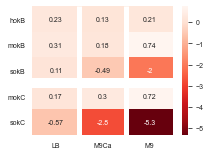

In [39]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (80/25.4, 60/25.4))
plt.rcParams["font.family"] = "Arial"
ax111 = fig.add_subplot(1,1,1)

ax111 = sns.heatmap(data = df_TA_filt_gpby_gpbyCOND_plot, 
                 cmap="Reds_r", annot = True, annot_kws={"size": 7})
ax111.hlines([3], *ax111.get_xlim(), color = 'white', linewidth = 10)
ax111.vlines([1,2], *ax111.get_ylim(), color = 'white', linewidth = 5)


cbar_axes = ax111.figure.axes[-1]
cbar_axes.tick_params(labelsize = 7)
plt.yticks(rotation = 0)
plt.tick_params('both',labelsize = 7)
plt.ylabel('');

plt.savefig('Section 3/SuppFig_hok-sok.pdf', type = 'pdf')

### Data Export

In [40]:
df_SuppFig5 = df_TA_filt_gpby_gpbyCOND_plot.reset_index()
df_SuppFig5.to_excel('Section 3/Table_SuppFig-5.xlsx')
df_SuppFig5

,gene_name_F2,LB,M9Ca,M9
0,hokB,0.227387,0.133371,0.205512
1,mokB,0.305539,0.183860,0.744690
2,sokB,0.109306,-0.490031,-2.048337
3,mokC,0.169569,0.295108,0.718726
4,sokC,-0.569456,-2.765518,-5.315158


## Supplementary Information: nadh:quinone oxidoreductase

### Visualize

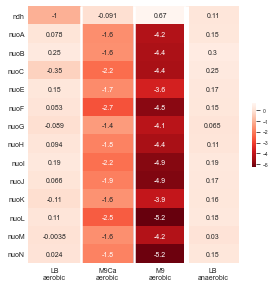

In [41]:
sns.set_style('white')
fig = plt.figure(figsize = (120/25.4,120/25.4))
#fig = plt.figure(figsize = (80/25.4, 60/25.4))
ax111 = fig.add_subplot(1,1,1)

gene_groups = aerobic_genes_NADH_quinone_oxidoreductase
genes_to_viz = gene_groups
df_comb_selgenes = df_comb[df_comb['gene_name_F2'].isin(genes_to_viz)]


sns.heatmap(df_comb_selgenes[[c for c in df_comb.columns if ('LR' in c)]], cmap="Reds_r", annot = True, annot_kws={"size": 7},
           cbar_kws = {'shrink': 0.25, 'aspect':20})

ax111.vlines([1,2], *ax111.get_ylim(), color = 'white', linewidth = 2.5)
ax111.vlines([3], *ax111.get_ylim(), color = 'white', linewidth = 5)
plt.yticks(rotation = 0);
plt.ylabel('')
plt.tick_params('both', labelsize = 7)
plt.xticks([0.5, 1.5, 2.5, 3.5], ['LB\naerobic', 'M9Ca\naerobic', 'M9\naerobic', 'LB\nanaerobic'], rotation = 0);

cbar = ax111.collections[0].colorbar
cbar.ax.tick_params(labelsize=5)

df_comb_selgenes_reind = df_comb_selgenes.reset_index(drop = True)
for i in df_comb_selgenes_reind[df_comb_selgenes_reind['Class(1:essential 2:noessential 3:unknown)'] == 1].index.values:
    ax111.get_yticklabels()[i].set_color('#AE282B')
ax111.get_xaxis().set_tick_params(direction='in', width=0)
ax111.get_yaxis().set_tick_params(direction='in', width=0)
    
plt.savefig('Section 3/SuppFig_AeVSAn_NADH-quinone-oxidoreductase.pdf', type = 'pdf')

### Data Export

In [42]:
df_SuppFig6 = df_comb_selgenes[[c for c in df_comb.columns if ('LB' in c and 'LR' in c)]].reset_index()
df_SuppFig6.to_excel('Section 3/Table_SuppFig-6.xlsx')
df_SuppFig6

,gene_name_F2,LB_ae_avgLR_nmed,LB_an_avgLR_nmed
0,ndh,-1.004246,0.114162
1,nuoA,0.077876,0.146489
2,nuoB,0.249683,0.302115
3,nuoC,-0.354993,0.245752
4,nuoE,0.152543,0.165525
5,nuoF,0.053034,0.147021
6,nuoG,-0.088803,0.065264
7,nuoH,0.094292,0.106420
8,nuoI,0.188959,0.186283
9,nuoJ,0.066267,0.168702
